In [5]:
# === Development Environment ===
"""
python version: 3.7.13 
pandas version: 1.3.4
numpy version: 1.21.5
biopython version: 1.79
matplotlib version: 3.5.1
seaborn version: 0.11.2
scipy version: 1.7.3
logomaker version: 0.8
scikit-learn version: 1.0.2
"""

'\npython version: 3.7.13 \npandas version: 1.3.4\nnumpy version: 1.21.5\nbiopython version: 1.79\nmatplotlib version: 3.5.1\nseaborn version: 0.11.2\nscipy version: 1.7.3\nlogomaker version: 0.8\nscikit-learn version: 1.0.2\n'

In [42]:
import pandas as pd
import numpy as np
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo
import logomaker
import matplotlib.pyplot as plt
import math
from itertools import combinations
import seaborn as sns
from Bio.SubsMat.MatrixInfo import blosum62
from scipy.stats import ttest_ind
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score

In [43]:
plt.rcParams['font.weight'] = 400
plt.rcParams['text.color'] = 'black'          
plt.rcParams['axes.labelcolor'] = 'black'     
plt.rcParams['xtick.color'] = 'black'         
plt.rcParams['ytick.color'] = 'black'         
plt.rcParams['axes.titlecolor'] = 'black'    
plt.rcParams['legend.labelcolor'] = 'black'   
plt.rcParams['pdf.fonttype'] = 42

In [8]:
flurry = pd.read_csv("../data/MHCflurry_filtered.csv") #run src/MHCflurry_data_prep.py
flurry['len'] = flurry['peptide'].str.len()
flurry = flurry[flurry['len'] == 9]
#run src/KMeans.py
clusters = pd.read_csv("../results/clustering_resC4.csv", index_col=0) 
clusters['normalized_HLA'] = clusters['HLA'].apply(lambda x: x.replace('*', ''))
cluster_map = clusters.set_index("normalized_HLA")["cluster"].to_dict()

pseudo_dict = {}

# pseudo seq data obtained from netMHCpan4.1b 
# Source: https://services.healthtech.dtu.dk/services/NetMHCpan-4.1/
# Note: This file is not included in this github repo 
with open("../data/MHC_pseudo.dat") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 2:
            pseudo_dict[parts[0]] = parts[1]
            
#run src/MHCflurry_data_prep.py
motif_df = pd.read_csv("../data/MHCflurry_training.csv", index_col=0)
motif_df.index = motif_df.index.str.upper().str.replace("*", "")

blosum62 = MatrixInfo.blosum62

/home/shepherd/anaconda3/envs/xgboost_env2/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [9]:
def blosum_score(seq1, seq2, matrix=blosum62):
    score = 0
    for a1, a2 in zip(seq1, seq2):
        if (a1, a2) in matrix:
            score += matrix[(a1, a2)]
        elif (a2, a1) in matrix:
            score += matrix[(a2, a1)]
        else:
            score -= 4
    return score

In [10]:
alleles = clusters["normalized_HLA"].tolist()
valid_alleles = [a for a in alleles if a in pseudo_dict]
print(f"Valid pseudo sequences found for {len(valid_alleles)} / {len(alleles)} alleles")

# Compute pairwise BLOSUM62 similarity
pair_scores = []
for a1, a2 in combinations(valid_alleles, 2):
    score = blosum_score(pseudo_dict[a1], pseudo_dict[a2])
    pair_scores.append(score)

mean_blosum = np.mean(pair_scores)
print(f"\nAverage BLOSUM62 similarity across all valid alleles: {mean_blosum:.2f}")

Valid pseudo sequences found for 107 / 107 alleles

Average BLOSUM62 similarity across all valid alleles: 110.24


In [11]:
AA_list = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
           'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

aa_color_dict = {
    # Hydrophobic
    'A': '#B8B8B8', 'V': '#B8B8B8', 'L': '#B8B8B8',
    'I': '#B8B8B8', 'M': '#B8B8B8', 'P': '#B8B8B8', 'G': '#B8B8B8',

    # Polar uncharged
    'S': '#92BEAA', 'T': '#92BEAA', 'N': '#92BEAA',
    'Q': '#92BEAA', 'C': '#92BEAA',

    # Positively charged
    'K': '#7E9AB2', 'R': '#7E9AB2', 'H': '#7E9AB2',

    # Negatively charged
    'D': '#F28482', 'E': '#F28482',

    # Aromatic
    'F': '#EDC264', 'W': '#EDC264', 'Y': '#EDC264'
}
def seqlogo_cluster_final(df, HLA, cluster_id, aa_color_dict, AA_list):
    cent_df = df[df["allele"] == HLA]
    fig, axes = plt.subplots(nrows=4, figsize=(6, 8), facecolor='none')
    lengths = [8, 9, 10, 11]

    max_length = 11  # set fixed max length for x-axis alignment

    for ax, i in zip(axes, lengths):
        len_group = cent_df.groupby('len')
        if i not in len_group.groups:
            ax.axis('off')
            continue

        peplist = len_group.get_group(i)["peptide"]
        split_pep = peplist.str.split("", expand=True).drop([0, i + 1], axis=1)
        split_pep.columns = range(i)

        pos_AA_p = pd.DataFrame(columns=AA_list)
        for y in range(i):
            AA_p = []
            entropy_lst = []
            for aa in AA_list:
                p = split_pep[y].tolist().count(aa) / len(peplist)
                AA_p.append(p)
                if p != 0:
                    entropy_lst.append(p * math.log(p, 2))
            R_ = math.log(20, 2) - (-1 * sum(entropy_lst) + (1 / math.log(2) * (20 - 1) / (2 * len(peplist))))
            pos_AA_p.loc[len(pos_AA_p)] = [item * R_ for item in AA_p]

        logomaker.Logo(pos_AA_p, ax=ax, color_scheme=aa_color_dict)
        ax.set_xlim(-0.5, max_length - 0.5)  # force same width for all logos
        ax.axis('off')

    fig.text(0.02, 0.5, f"Cluster {cluster_id}", fontsize=14, fontweight='bold', rotation=90, va='center')
    fig.suptitle(HLA, fontsize=16, fontweight='bold')

    plt.subplots_adjust(hspace=0.1)
    plt.savefig(f"figures/{HLA}_cluster{cluster_id}_logo_stack_final.png", dpi=300, transparent=True, bbox_inches='tight')
    plt.show()

In [12]:
# === Main Analysis ===
cluster_to_alleles = clusters.groupby("cluster")["normalized_HLA"].apply(list).to_dict()

In [37]:
def seqlogo_cluster_aligned(df, HLA, cluster_id):
    cent_df = df[df["allele"] == HLA]
    lengths = [8, 9, 10, 11]
    
    max_length = cent_df["len"].max()*1.2
    available_lengths = sorted(cent_df["len"].unique())
    nrows = len(available_lengths)

    fig, axes = plt.subplots(nrows=nrows, figsize=(5, 2 * nrows), 
                             facecolor='none', constrained_layout=False)

    if nrows == 1:
        axes = [axes]

    idx = 0
    for idx, i in enumerate(available_lengths):
        if i not in available_lengths:
            continue
        
        peplist = cent_df[cent_df["len"] == i]["peptide"]
        split_pep = peplist.str.split("", expand=True).drop([0, i + 1], axis=1)
        split_pep.columns = range(i)

        pos_AA_p = pd.DataFrame(columns=AA_list)
        for y in range(i):
            AA_p = []
            entropy_lst = []
            for aa in AA_list:
                p = split_pep[y].tolist().count(aa) / len(peplist)
                AA_p.append(p)
                if p != 0:
                    entropy_lst.append(p * math.log(p, 2))
            R_ = math.log(20, 2) - (-1 * sum(entropy_lst) + (1 / math.log(2) * (20 - 1) / (2 * len(peplist))))
            pos_AA_p.loc[len(pos_AA_p)] = [item * R_ for item in AA_p]

        # ✅ Plot with your color scheme
        logomaker.Logo(pos_AA_p, ax=axes[idx], color_scheme=aa_color_dict)

        # ✅ Style the axis
        axes[idx].set_facecolor('none')
        axes[idx].tick_params(axis='both', which='both', labelsize=14)
        axes[idx].spines['right'].set_visible(False)
        axes[idx].spines['top'].set_visible(False)

        axes[idx].set_xticks([])
        shrink_factor = 0.7
        overlap_factor = 1.3   # 1.2 ~ tight, 1.4 ~ loose
        box = axes[idx].get_position()

        scale = i / max_length
        new_width = box.width * scale
        dy = box.height * shrink_factor * overlap_factor
        y_start = 0.9  # top starting position (adjust to fit your title)

        new_y = y_start - idx * dy

        axes[idx].set_position([
            box.x0,
            new_y,
            new_width,
            box.height * shrink_factor
        ])
        idx += 1
    
    # ✅ Left-aligned HLA label
    fig.suptitle(HLA, fontsize=20, fontweight='regular', x=0.12, y=1.68, ha='left')
    
    # ✅ Save or show
    plt.savefig(f"figures/{HLA}_cluster{cluster_id}_logo_stack_final.png", dpi=300, transparent=True, bbox_inches='tight')
    plt.show()


In [38]:
def add_star(allele):
    if "*" not in allele and allele.startswith("HLA-"):
        parts = allele.split("-")[1]  # B51:01
        gene = parts[0]               # B
        rest = parts[1:]              # 51:01
        return f"HLA-{gene}*{rest}"
    return allele


Cluster 0 (Top 3 pairs by motif similarity):
[✓] HLA-B51:01 vs HLA-C02:02 | Motif Similarity = -0.124 | Pseudo BLOSUM = 90
0


/home/shepherd/anaconda3/envs/xgboost_env2/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


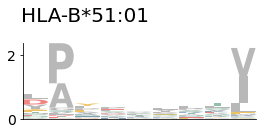

0


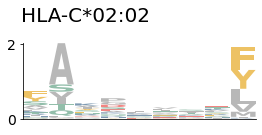

--- BLOSUM62 alignment ---
YYATYRNIFTNTYENIAYWTYNYYTWAELAYLWH
|||.||.....|..|..|..|..|||||.||.|.
YYAGYREKYRQTDVNKLYLRYDSYTWAEWAYEWY
  Score=90

[✓] HLA-B57:03 vs HLA-C03:04 | Motif Similarity = -0.126 | Pseudo BLOSUM = 105
0


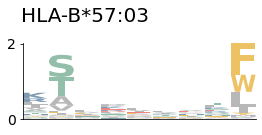

0


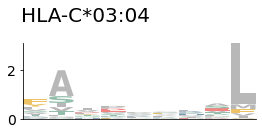

--- BLOSUM62 alignment ---
YYAMYGENMASTYENIAYIVYNYYTWAVLAYLWY
|||.|.|....|.....||.|.|||||.||||||
YYAGYREKYRQTDVSNLYIRYDYYTWAELAYLWY
  Score=105

[✓] HLA-B57:03 vs HLA-C08:01 | Motif Similarity = -0.153 | Pseudo BLOSUM = 101
0


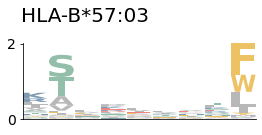

0


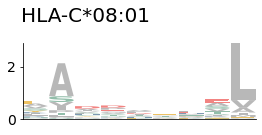

--- BLOSUM62 alignment ---
YYAMYGENMASTYENIAYIVYNYYTWAVLAYLWY
|||.|.|....|.....|..||.||||.|||.||
YYAGYREKYRQTDVSNLYLRYNFYTWATLAYTWY
  Score=101


Cluster 1 (Top 3 pairs by motif similarity):
[✓] HLA-B07:02 vs HLA-B49:01 | Motif Similarity = -0.125 | Pseudo BLOSUM = 96
1


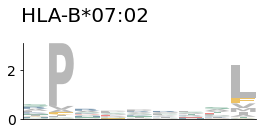

1


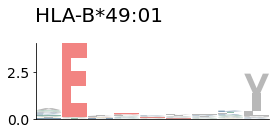

--- BLOSUM62 alignment ---
YYSEYRNIYAQTDESNLYLSYDYYTWAERAYEWY
|...||.|...|.|...|..|..|||||.||.||
YHTKYREISTNTYENIAYWRYNLYTWAELAYLWY
  Score=96

[✓] HLA-B42:01 vs HLA-B49:01 | Motif Similarity = -0.144 | Pseudo BLOSUM = 94
1


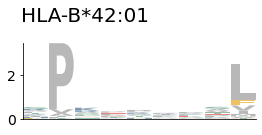

1


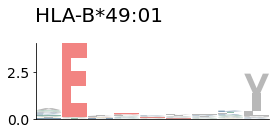

--- BLOSUM62 alignment ---
YYSEYRNIYAQTDESNLYLSYNYYTWAVDAYTWY
|...||.|...|.|...|..||.||||..||.||
YHTKYREISTNTYENIAYWRYNLYTWAELAYLWY
  Score=94

[✓] HLA-A02:01 vs HLA-C14:02 | Motif Similarity = -0.146 | Pseudo BLOSUM = 93
1


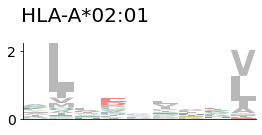

1


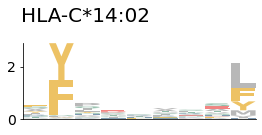

--- BLOSUM62 alignment ---
YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY
|.|.|.||...|.|..||.....||||..|||||
YSAGYREKYRQTDVSNLYLWFDSYTWAERAYTWY
  Score=93


Cluster 2 (Top 3 pairs by motif similarity):
[✓] HLA-B58:01 vs HLA-C03:03 | Motif Similarity = -0.141 | Pseudo BLOSUM = 110
2


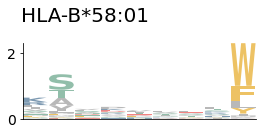

2


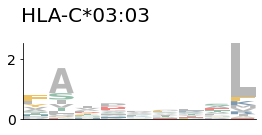

--- BLOSUM62 alignment ---
YYATYGENMASTYENIAYIRYDSYTWAVLAYLWY
|||.|.|....|.....|||||.||||.||||||
YYAGYREKYRQTDVSNLYIRYDYYTWAELAYLWY
  Score=110

[✓] HLA-B57:01 vs HLA-C03:03 | Motif Similarity = -0.149 | Pseudo BLOSUM = 101
2


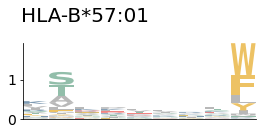

2


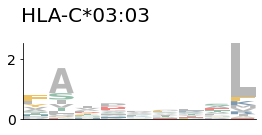

--- BLOSUM62 alignment ---
YYAMYGENMASTYENIAYIVYDSYTWAVLAYLWY
|||.|.|....|.....||.||.||||.||||||
YYAGYREKYRQTDVSNLYIRYDYYTWAELAYLWY
  Score=101

[✓] HLA-A66:01 vs HLA-B57:01 | Motif Similarity = -0.180 | Pseudo BLOSUM = 103
2


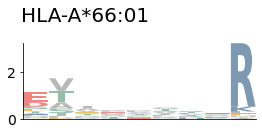

2


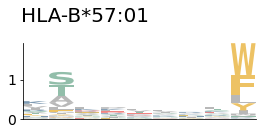

--- BLOSUM62 alignment ---
YYAMYRNNVAQTDVDTLYIRYQDYTWAEWAYRWY
|||||..|.|.|.....||.|..||||..||.||
YYAMYGENMASTYENIAYIVYDSYTWAVLAYLWY
  Score=103


Cluster 3 (Top 3 pairs by motif similarity):
[✓] HLA-A36:01 vs HLA-C01:02 | Motif Similarity = -0.256 | Pseudo BLOSUM = 94
3


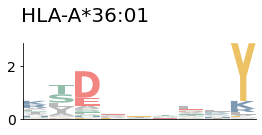

3


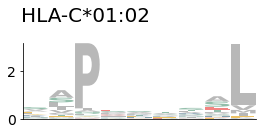

--- BLOSUM62 alignment ---
YFAMYQENMAHTDANTLYIIYRDYTWVARVYTWY
||..|.|....||...||.....|||..|.||||
YFSGYREKYRQTDVSNLYLWCDYYTWAERAYTWY
  Score=94

[✓] HLA-A01:01 vs HLA-C01:02 | Motif Similarity = -0.261 | Pseudo BLOSUM = 75
3


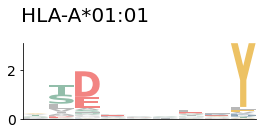

3


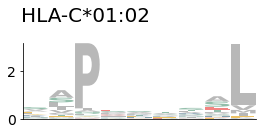

--- BLOSUM62 alignment ---
YFAMYQENMAHTDANTLYIIYRDYTWVARVYRGY
||..|.|....||...||.....|||..|.|..|
YFSGYREKYRQTDVSNLYLWCDYYTWAERAYTWY
  Score=75

[✓] HLA-A02:07 vs HLA-C04:01 | Motif Similarity = -0.312 | Pseudo BLOSUM = 98
3


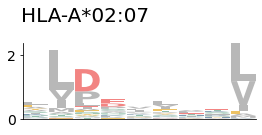

3


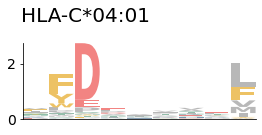

--- BLOSUM62 alignment ---
YFAMYGEKVAHTHVDTLYVRCHYYTWAVLAYTWY
|.|.|.||.....|..||.|...||||..|||||
YSAGYREKYRQADVNKLYLRFNFYTWAERAYTWY
  Score=98



In [39]:
# === Loop clusters and filter ===
for cluster_id, alleles in cluster_to_alleles.items():
    print(f"\nCluster {cluster_id} (Top 3 pairs by motif similarity):")
    pair_scores = []

    for a1, a2 in combinations(alleles, 2):
        if (
            a1 in motif_df.index and a2 in motif_df.index and
            a1 in pseudo_dict and a2 in pseudo_dict
        ):
            # Compute pseudo similarity
            pseudo_sim = blosum_score(pseudo_dict[a1], pseudo_dict[a2])
            if pseudo_sim > mean_blosum:
                continue  

            motif_sim = -np.linalg.norm(motif_df.loc[a1] - motif_df.loc[a2])
            pair_scores.append((a1, a2, motif_sim, pseudo_sim))

    if not pair_scores:
        print("  No qualifying pairs after filtering.")
        continue

    top3 = sorted(pair_scores, key=lambda x: x[2], reverse=True)[:3]

    for a1, a2, score, pseudo_sim in top3:
        print(f"[✓] {a1} vs {a2} | Motif Similarity = {score:.3f} | Pseudo BLOSUM = {pseudo_sim}")

        # Plot logos
        for allele in [a1, a2]:
            peptides = flurry[flurry["allele"].str.replace("*", "") == allele]["peptide"]
            print(cluster_id)
            seqlogo_cluster_aligned(flurry, add_star(allele), int(cluster_id)+1)

        # Alignment
        aln = pairwise2.format_alignment(*pairwise2.align.globalds(
            pseudo_dict[a1], pseudo_dict[a2], blosum62, -10, -0.5, one_alignment_only=True)[0])
        print(f"--- BLOSUM62 alignment ---\n{aln}")

In [ ]:
seqlogo_cluster_aligned(flurry, add_star(allele), int(cluster_id)+1)

In [16]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, mutual_info_score
from tqdm import tqdm

# Load BLOSUM62 matrix
blosum = MatrixInfo.blosum62
aas = sorted(set([aa for pair in blosum.keys() for aa in pair]))  # unique AAs
aa_to_index = {aa: i for i, aa in enumerate(aas)}

def aa_blosum_vec(aa):
    vec = np.zeros(len(aas))
    for i, target_aa in enumerate(aas):
        if (aa, target_aa) in blosum:
            vec[i] = blosum[(aa, target_aa)]
        elif (target_aa, aa) in blosum:
            vec[i] = blosum[(target_aa, aa)]
        else:
            vec[i] = -4  # typical penalty
    return vec

def sequence_embedding(seq):
    return np.mean([aa_blosum_vec(aa) for aa in seq], axis=0)

cluster_alleles = set(clusters["normalized_HLA"])

filtered_pseudo_dict = {
    hla: seq for hla, seq in pseudo_dict.items()
    if hla.upper().replace("*", "").replace(":", "") in cluster_alleles
}

alleles, features = [], []
for hla in cluster_alleles:
    normed = hla.replace("*", "").upper()
    if normed in pseudo_dict:
        alleles.append(hla)  # use normalized form
        features.append(sequence_embedding(pseudo_dict[normed]))
    else:
        print(f"Missing in pseudo_dict: {hla}")

X = np.vstack(features)
pseudo_df = pd.DataFrame(X, index=alleles)

In [48]:
pseudo_df.shape

(107, 23)

In [17]:
# KMeans clustering on BLOSUM embeddings
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(pseudo_df)

pseudo_cluster_df = pd.DataFrame({
    "HLA": alleles,
    "pseudo_cluster": cluster_labels,
})

pseudo_cluster_df["normalized_HLA"] = pseudo_cluster_df["HLA"].str.upper().str.replace("*", "")
assert len(pseudo_df) == len(clusters), f"Mismatch: {len(pseudo_df)} vs {len(clusters)}"

merged = pd.merge(clusters, pseudo_cluster_df, on="normalized_HLA")

ari = adjusted_rand_score(merged["cluster"], merged["pseudo_cluster"])
mi = mutual_info_score(merged["cluster"], merged["pseudo_cluster"])

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Mutual Information (MI): {mi:.4f}")

Adjusted Rand Index (ARI): 0.1172
Mutual Information (MI): 0.2166


/home/shepherd/anaconda3/envs/xgboost_env2/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # This is added back by InteractiveShellApp.init_path()


In [44]:
from matplotlib.font_manager import FontProperties

def plot_pseudo_clustering_pca(pca_df, cluster_labels, K):
    LABEL_COLOR_MAP = {
        0: '#7E9AB2', 1: '#EDC264', 2: '#F28482', 3: '#92BEAA',
        4: '#F5CAC3', 5: '#B8B8B8'
    }

    df_plot = pd.DataFrame({
        "PC1": pca_df[:, 0],
        "PC2": pca_df[:, 1],
        "Cluster": cluster_labels
    })

    fig, ax = plt.subplots(figsize=(9, 6.5), facecolor='none')
    ax.set_facecolor('none')  
    ax.grid(False)

    for cluster_id in sorted(df_plot["Cluster"].unique()):
        cluster_points = df_plot[df_plot["Cluster"] == cluster_id]
        ax.scatter(
            cluster_points["PC1"],
            cluster_points["PC2"],
            label=f"Cluster {cluster_id + 1}",
            color=LABEL_COLOR_MAP[cluster_id],
            s=80,
            edgecolors='#747474',
            linewidth=0.5, 
            alpha = 1
        )
        
    ax.set_xlabel("PC 1", fontsize=18, fontweight='regular', labelpad=20)
    ax.set_ylabel("PC 2", fontsize=18, fontweight='regular', labelpad=15)
    ax.set_title(f"Pseudo Sequence Clustering (BLOSUM62) (K={K})", fontsize=20, fontweight='regular', pad=20)

    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_edgecolor("black")  # Set border color to black
        spine.set_visible(True)

    ax.tick_params(axis='both', labelsize=16)
    plt.xticks(fontsize=16, fontweight='regular')
    plt.yticks(fontsize=16, fontweight='regular')

    bold_font = FontProperties(weight='regular')
    ax.legend(
        title='Clusters',
        fontsize=14,
        title_fontproperties=bold_font,
        prop={'weight': 'regular'},
        loc='upper left',
        bbox_to_anchor=(1.05, 1),
        frameon=False
    )

    plt.tight_layout()
    plt.savefig(f"figures/pseudo_clustering_blosum62_k{K}.png", dpi=300, transparent=True)
    plt.savefig(f"figures/pdf/pseudo_clustering_blosum62_k{K}.pdf", dpi=300, transparent=True)
    plt.show()
    plt.close()

[0 0 3 2 0 1 3 0 0 3 2 3 1 0 3 2 1 3 3 2 3 1 3 2 1 0 2 2 3 1 3 3 0 3 1 0 1
 3 2 2 2 3 0 2 3 0 3 3 3 2 2 0 2 1 3 0 1 2 3 3 0 2 0 1 2 1 2 2 3 2 3 3 0 2
 1 1 2 0 3 3 0 2 3 0 1 1 2 3 2 0 0 2 0 2 3 0 3 0 0 0 0 3 1 0 3 0 0]


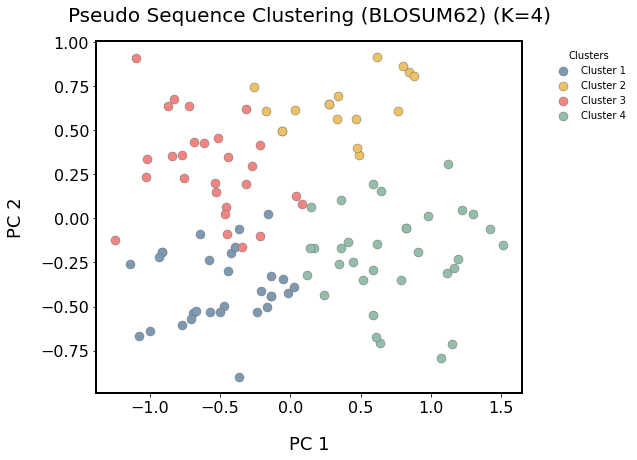

In [45]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(pseudo_df)
print(cluster_labels)
plot_pseudo_clustering_pca(reduced, cluster_labels=cluster_labels, K=4)

In [20]:
pca_df = pd.read_csv("../data/tier1_hla_pca.csv", index_col = 0)

In [21]:
X_sub = pseudo_df.loc[merged["normalized_HLA"]].to_numpy()

mms_labels = merged["cluster"].values
pseudo_labels = merged["pseudo_cluster"].values

mms_score = silhouette_score(pca_df, mms_labels)
pseudo_score = silhouette_score(X_sub, pseudo_labels)

print(f"MMS clustering silhouette: {mms_score:.3f}")
print(f"Pseudo sequence clustering silhouette: {pseudo_score:.3f}")

MMS clustering silhouette: 0.433
Pseudo sequence clustering silhouette: 0.244


In [22]:
#run src/MHCflurry_data_prep.py
training = pd.read_csv("../data/MHCflurry_training.csv", index_col=0)

In [23]:
ch_mms = calinski_harabasz_score(training, clusters["cluster"])
ch_pseudo = calinski_harabasz_score(X, merged["pseudo_cluster"])
print(f"CH Score (MMS): {ch_mms:.2f}")
print(f"CH Score (Pseudo): {ch_pseudo:.2f}")

CH Score (MMS): 44.59
CH Score (Pseudo): 0.59


In [24]:
scores = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42).fit(X)
    score = silhouette_score(X, km.labels_)
    scores.append(score)

In [25]:
scores

[0.29263660050440937,
 0.23505733504241205,
 0.24380348838825674,
 0.2547649700693816,
 0.220913766345116,
 0.21811661173770402,
 0.23590141975506795,
 0.22618966278329655]

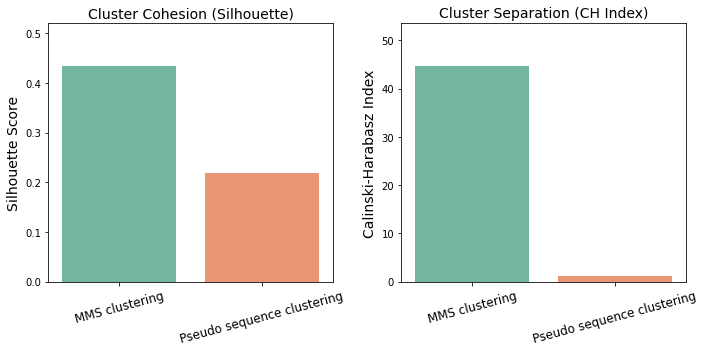

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Replace these with your actual values
methods = ["MMS clustering", "Pseudo sequence clustering"]
silhouette_scores = [0.433, 0.218]
ch_scores = [44.59, 1.12]

plt.figure(figsize=(10, 5))

# Plot silhouette scores
plt.subplot(1, 2, 1)
sns.barplot(x=methods, y=silhouette_scores, palette="Set2")
plt.ylabel("Silhouette Score", fontsize=14, weight='regular')
plt.xticks(rotation=15, fontsize=12)
plt.title("Cluster Cohesion (Silhouette)", fontsize=14, weight='regular')
plt.ylim(0, max(silhouette_scores)*1.2)

# Plot CH index
plt.subplot(1, 2, 2)
sns.barplot(x=methods, y=ch_scores, palette="Set2")
plt.ylabel("Calinski-Harabasz Index", fontsize=14, weight='regular')
plt.xticks(rotation=15, fontsize=12)
plt.title("Cluster Separation (CH Index)", fontsize=14, weight='regular')
plt.ylim(0, max(ch_scores)*1.2)

plt.tight_layout()
#plt.savefig("figures/cluster_eval_scores.png", dpi=300, transparent=True)
plt.show()

In [27]:
pseudo_cluster_df["locus"] = pseudo_cluster_df["HLA"].str.extract(r'HLA-([ABC])')
cluster_locus_counts = pseudo_cluster_df.groupby(["pseudo_cluster", "locus"]).size().unstack(fill_value=0)
print(cluster_locus_counts)

locus            A   B   C
pseudo_cluster            
0                4   8  18
1               17   0   0
2                1  23   3
3               10  23   0


locus     A   B   C
cluster            
0        13  13  12
1         2  38   3
2        14   3   1
3         3   0   5


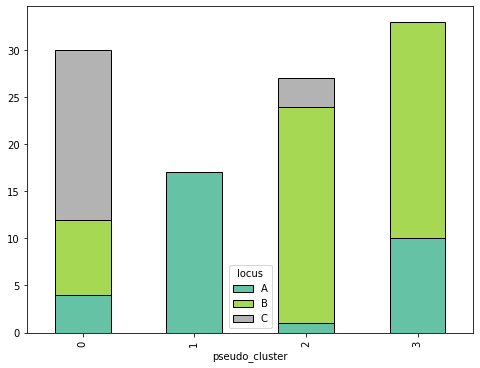

In [28]:
import matplotlib.pyplot as plt

cluster_locus_counts.plot(
    kind="bar",
    stacked=True,
    colormap="Set2",
    figsize=(8, 6),
    edgecolor='black'
)

clusters["locus"] = clusters["HLA"].str.extract(r'HLA-([ABC])')
mms_cluster_locus_counts = clusters.groupby(["cluster", "locus"]).size().unstack(fill_value=0)
print(mms_cluster_locus_counts)

locus     A   B   C
cluster            
0        13  13  12
1         2  38   3
2        14   3   1
3         3   0   5


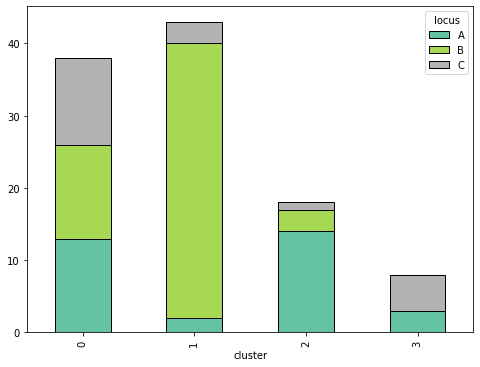

In [29]:
import matplotlib.pyplot as plt

mms_cluster_locus_counts.plot(
    kind="bar",
    stacked=True,
    colormap="Set2",
    figsize=(8, 6),
    edgecolor='black'
)
valid_alleles = [a for a in cluster_map if a in pseudo_dict]
filtered_clusters = {a: cluster_map[a] for a in valid_alleles}
alleles = list(filtered_clusters.keys())
cluster_ids = sorted(set(filtered_clusters.values()))
print(mms_cluster_locus_counts)

In [30]:
def blosum_score(seq1, seq2, matrix=blosum62):
    score = 0
    for a1, a2 in zip(seq1, seq2):
        if (a1, a2) in matrix:
            score += matrix[(a1, a2)]
        elif (a2, a1) in matrix:
            score += matrix[(a2, a1)]
        else:
            score += -4
    return score

In [31]:
for idx, cid in enumerate(cluster_ids, 1):
    intra_scores, inter_scores = [], []
    current = [a for a in alleles if filtered_clusters[a] == cid]
    others = [a for a in alleles if filtered_clusters[a] != cid]

    # Intra-cluster pairs
    for a1, a2 in combinations(current, 2):
        intra_scores.append(blosum_score(pseudo_dict[a1], pseudo_dict[a2]))

    # Inter-cluster pairs (current vs. outside)
    for a1 in current:
        for a2 in others:
            inter_scores.append(blosum_score(pseudo_dict[a1], pseudo_dict[a2]))

    df_plot = pd.DataFrame({
        "Similarity": intra_scores + inter_scores,
        "Type": ["Intra-cluster"] * len(intra_scores) + ["Inter-cluster"] * len(inter_scores)
    })
    #df_plot.to_csv(f"../results/per_cluster{cid+1}_blosum_violin.csv", index = False)

# plt.savefig("figures/per_cluster_blosum_violin.png", dpi=300, transparent=True)
# plot in PRISM graphpad